In [251]:
pip install pmdarima

In [252]:
import numpy as np
import scipy as sp
import pandas as pd
from pandas.plotting import autocorrelation_plot
from datetime import datetime
from datetime import timedelta
import statsmodels
import os
import sys
import time
import requests
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from pylab import rcParams
import itertools
import statsmodels.tsa.api as smt
from itertools import product
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

rcParams['figure.figsize'] = 11, 9

In [253]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [254]:
# df_TR = pd.read_csv('Transactions.csv', parse_dates = ['TransactionDate'], index_col='TransactionDate', dayfirst = True)
df_TR = pd.read_csv('/content/drive/MyDrive/Institute_of_Data/Mini Project/Mini_Project_3/Transactions.csv', parse_dates = ['TransactionDate'], index_col='TransactionDate', dayfirst = True, encoding='cp1252')
df_TR.head()

,StockID,Part,StockDescription,TransactionID,SourceTypeID,SourceType,SourceID,Reference,Detail,Qty,Cost,CostEach,Amount,New Total Qty,DocumentID,Contact
TransactionDate,,,,,,,,,,,,,,,,
2020-07-31,4283,10I-SERIES,NaN,5070,29,Supplier Invoice,132,OT30016,104,1.0,942.85,942.85,0.0,1.0,27.0,Automotive Test Solutions - ATS
2020-09-15,4283,10I-SERIES,NaN,7726,21,Customer Invoice,4244,OT45431,N046749,-1.0,-942.85,942.85,1450.0,0.0,1498.0,Wittaya Mala
2021-04-12,4581,AIR-CPM-20,"1/4"" Male Swivel Joint",21036,29,Supplier Invoice,1644,OT30175,VTIV0004975,5.0,57.85,11.57,0.0,5.0,198.0,TENG TOOLS
2021-05-25,4615,AIR-CSW-02,Universal Swivel Joint - Block Style,23825,29,Supplier Invoice,1759,OT30205,VITV0005582,2.0,23.74,11.87,0.0,2.0,228.0,TENG TOOLS
2020-07-06,1,AIR-R420FC,"1/4"" Female Coupler R420FC",2513,29,Supplier Invoice,2,OT30001,VTIV0001018,25.0,145.00,5.80,0.0,32.0,1.0,TENG TOOLS


In [255]:
df_TR.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29025 entries, 2020-07-31 to 2021-06-30
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   StockID           29025 non-null  int64  
 1   Part              29025 non-null  object 
 2   StockDescription  28595 non-null  object 
 3   TransactionID     29025 non-null  int64  
 4   SourceTypeID      29025 non-null  int64  
 5   SourceType        29025 non-null  object 
 6   SourceID          29025 non-null  int64  
 7   Reference         29025 non-null  object 
 8   Detail            16726 non-null  object 
 9   Qty               29025 non-null  float64
 10  Cost              29022 non-null  float64
 11  CostEach          29022 non-null  float64
 12  Amount            29025 non-null  float64
 13  New Total Qty     13645 non-null  float64
 14  DocumentID        27211 non-null  float64
 15  Contact           28272 non-null  object 
dtypes: float64(6), int64(4)

In [256]:
df_TR.dropna(subset=['New Total Qty'], inplace=True)

In [257]:
df_TR.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13645 entries, 2020-07-31 to 2021-06-30
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   StockID           13645 non-null  int64  
 1   Part              13645 non-null  object 
 2   StockDescription  13352 non-null  object 
 3   TransactionID     13645 non-null  int64  
 4   SourceTypeID      13645 non-null  int64  
 5   SourceType        13645 non-null  object 
 6   SourceID          13645 non-null  int64  
 7   Reference         13645 non-null  object 
 8   Detail            10720 non-null  object 
 9   Qty               13645 non-null  float64
 10  Cost              13642 non-null  float64
 11  CostEach          13642 non-null  float64
 12  Amount            13645 non-null  float64
 13  New Total Qty     13645 non-null  float64
 14  DocumentID        12375 non-null  float64
 15  Contact           13434 non-null  object 
dtypes: float64(6), int64(4)

In [258]:
df_TR['SourceType'].unique()

array(['Supplier Invoice', 'Customer Invoice', 'Customer Invoice Undo',
       'Adjustment', 'Customer Credit Note', 'Supplier Credits'],
      dtype=object)

In [259]:
# Selecting just purchases
pur_df = df_TR[df_TR['SourceTypeID'].isin([21,200])]
pur_df.head()

,StockID,Part,StockDescription,TransactionID,SourceTypeID,SourceType,SourceID,Reference,Detail,Qty,Cost,CostEach,Amount,New Total Qty,DocumentID,Contact
TransactionDate,,,,,,,,,,,,,,,,
2020-09-15,4283,10I-SERIES,NaN,7726,21,Customer Invoice,4244,OT45431,N046749,-1.0,-942.85,942.85,1450.00,0.0,1498.0,Wittaya Mala
2020-07-22,1,AIR-R420FC,"1/4"" Female Coupler R420FC",3135,21,Customer Invoice,561,OT43899,N046008,-1.0,-5.80,5.80,9.88,31.0,185.0,Jake Stalker
2020-07-22,1,AIR-R420FC,"1/4"" Female Coupler R420FC",3171,21,Customer Invoice,636,OT43911,N046021,-1.0,-5.80,5.80,9.88,30.0,210.0,David Kidd
2020-07-22,1,AIR-R420FC,"1/4"" Female Coupler R420FC",3210,21,Customer Invoice,707,OT43923,N046036,-1.0,-5.80,5.80,9.88,29.0,233.0,THERESA Wilson
2020-07-22,1,AIR-R420FC,"1/4"" Female Coupler R420FC",3327,21,Customer Invoice,936,OT43966,N046080,-1.0,-5.80,5.80,9.88,28.0,303.0,Joel Hili


In [260]:
pur_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10611 entries, 2020-09-15 to 2020-07-28
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   StockID           10611 non-null  int64  
 1   Part              10611 non-null  object 
 2   StockDescription  10465 non-null  object 
 3   TransactionID     10611 non-null  int64  
 4   SourceTypeID      10611 non-null  int64  
 5   SourceType        10611 non-null  object 
 6   SourceID          10611 non-null  int64  
 7   Reference         10611 non-null  object 
 8   Detail            8015 non-null   object 
 9   Qty               10611 non-null  float64
 10  Cost              10611 non-null  float64
 11  CostEach          10611 non-null  float64
 12  Amount            10611 non-null  float64
 13  New Total Qty     10611 non-null  float64
 14  DocumentID        10597 non-null  float64
 15  Contact           10597 non-null  object 
dtypes: float64(6), int64(4)

In [261]:
ts = pur_df.resample('w').sum()['Qty']*-1
ts

TransactionDate
2020-07-05      2.0
2020-07-12     10.0
2020-07-19      6.0
2020-07-26    355.0
2020-08-02    412.0
              ...  
2021-09-05    207.0
2021-09-12    183.0
2021-09-19    173.0
2021-09-26    112.0
2021-10-03    186.0
Freq: W-SUN, Name: Qty, Length: 66, dtype: float64

In [262]:
ts.describe()

count     66.000000
mean     176.606061
std       83.708998
min        2.000000
25%      132.500000
50%      172.000000
75%      205.500000
max      470.000000
Name: Qty, dtype: float64

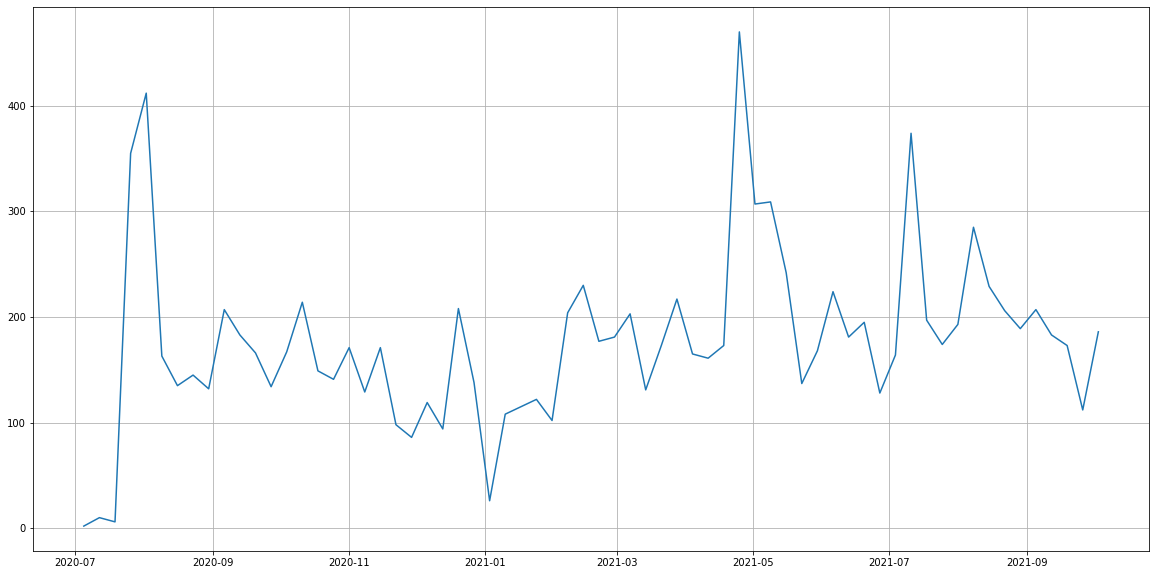

In [263]:
plt.figure(figsize=(20, 10))
plt.plot(ts)
plt.grid(True)
plt.show()

In [264]:
# Remove Trend
ts_diff = ts.diff()[1:]

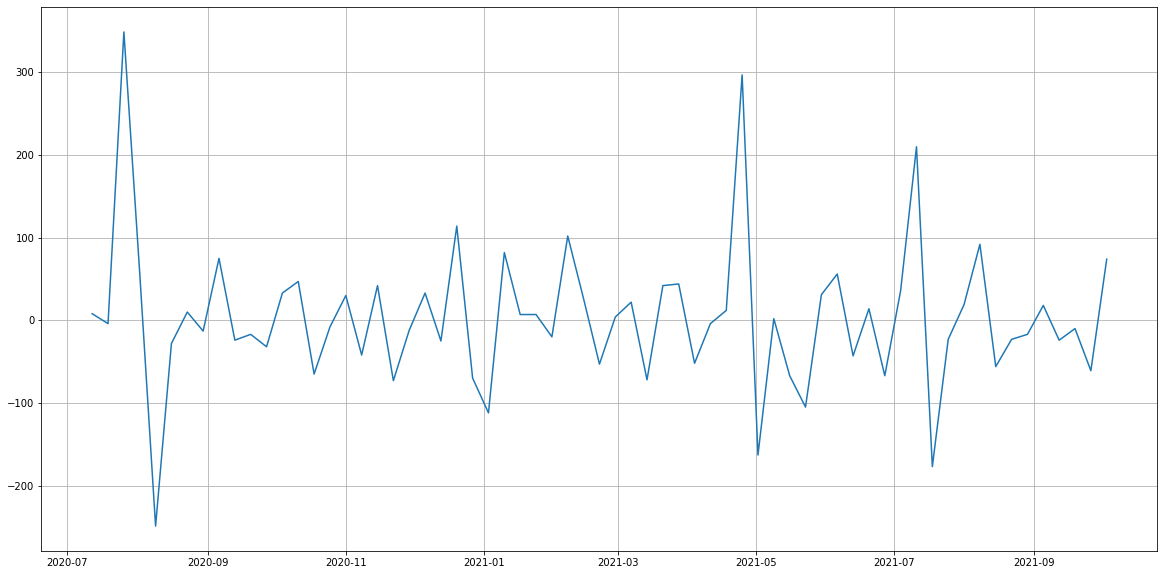

In [265]:
plt.figure(figsize=(20, 10))
plt.plot(ts_diff)
plt.grid(True)
plt.show()

In [266]:
# Check Stationarity

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(10).mean()
    rolstd = timeseries.rolling(10).std()

    #Plot rolling statistics:
    plt.figure(figsize=(11, 9))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

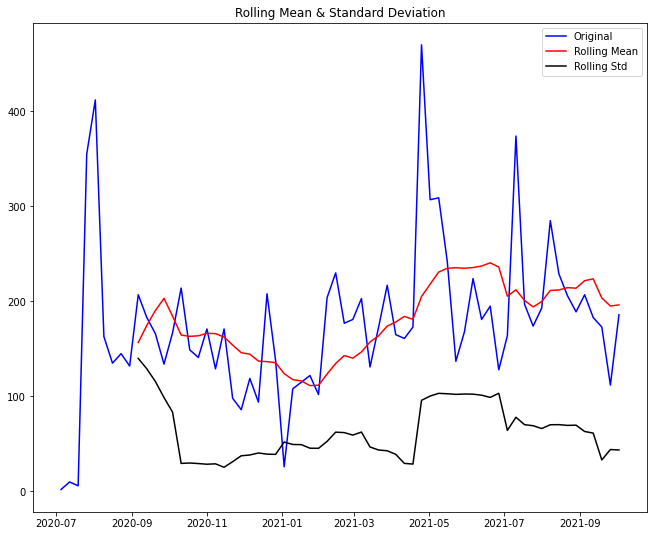

Results of Dickey-Fuller Test:
Test Statistic                 -5.445042
p-value                         0.000003
#Lags Used                      0.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


In [267]:
test_stationarity(ts)

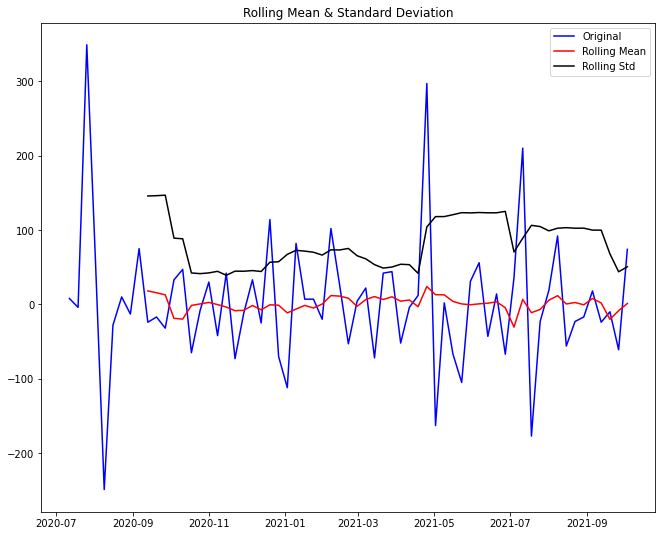

Results of Dickey-Fuller Test:
Test Statistic                -7.829554e+00
p-value                        6.346732e-12
#Lags Used                     2.000000e+00
Number of Observations Used    6.200000e+01
Critical Value (1%)           -3.540523e+00
Critical Value (5%)           -2.909427e+00
Critical Value (10%)          -2.592314e+00
dtype: float64


In [268]:
test_stationarity(ts_diff)

In [269]:
from statsmodels.tsa.stattools import acf, pacf

def plot_acf_pacf(x): 
    lag_acf = acf(x, nlags=10)
    lag_pacf = pacf(x, nlags=10, method='ols')

    #Plot ACF: 
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

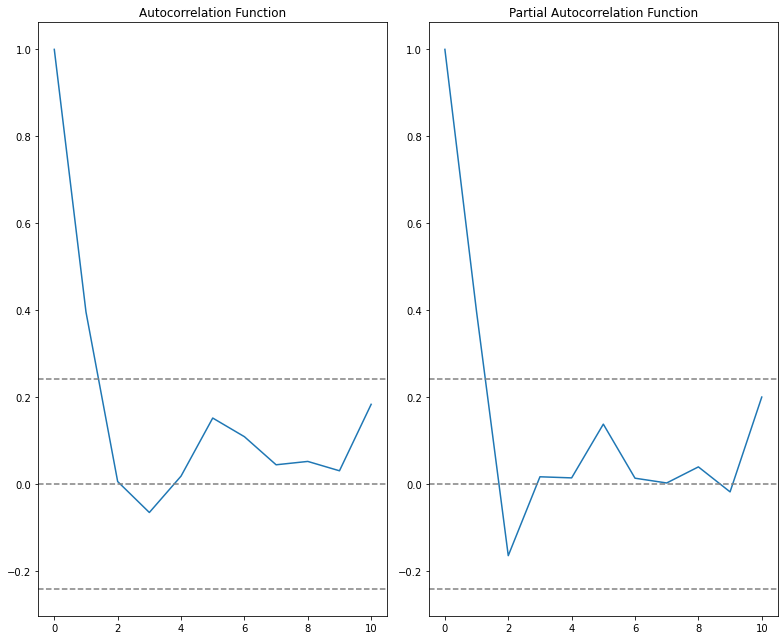

In [270]:
plot_acf_pacf(ts)

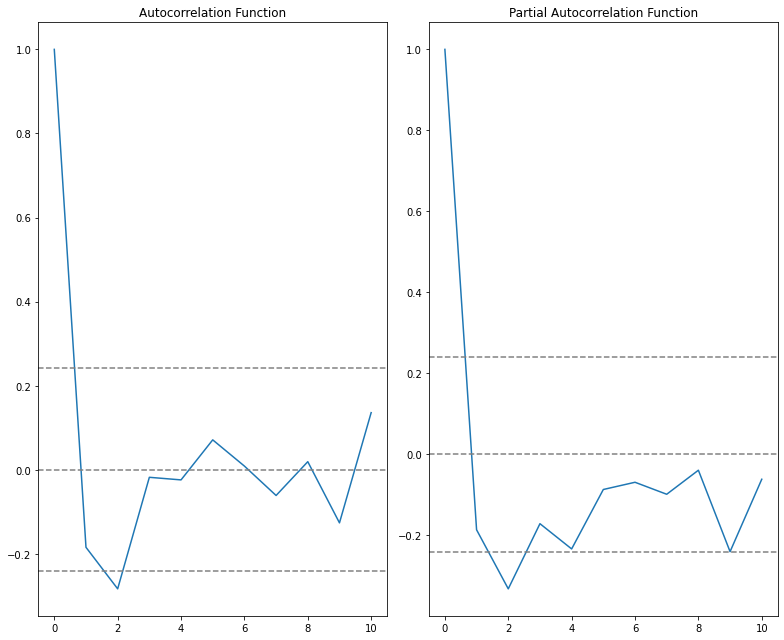

In [271]:
plot_acf_pacf(ts_diff)

In [272]:
from pmdarima.model_selection import train_test_split
train, test = train_test_split(ts, train_size = 0.7)
print(train.shape)
print(test.shape)
print(ts.shape)

(46,)
(20,)
(66,)


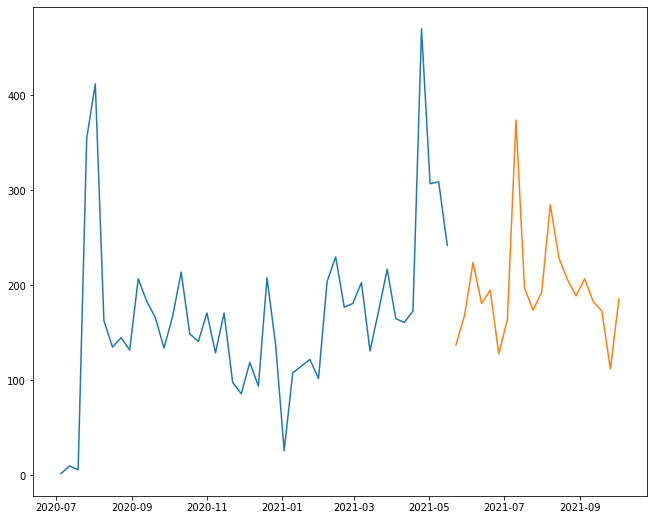

In [273]:
plt.plot(train)
plt.plot(test)

In [394]:
model=auto_arima(train,start_p=0,d=1,start_q=0,
          max_p=7,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=7,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=46,n_fits=300)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=421.016, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=417.203, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=415.088, Time=0.19 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=415.041, Time=0.05 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=414.651, Time=0.17 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=416.604, Time=0.58 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=416.604, Time=0.32 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=418.604, Time=0.63 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=416.667, Time=0.09 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=413.754, Time=0.42 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=415.197, Time=0.15 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=415.749, Time=1.10 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=415.749, Time=0.59 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=414.300, Time=0.47 sec
 ARIMA(1,1,1)(2,1,1)[12]         

In [395]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   46
Model:             SARIMAX(0, 1, 2)x(1, 1, [], 12)   Log Likelihood                -202.568
Date:                             Mon, 11 Oct 2021   AIC                            413.135
Time:                                     05:46:32   BIC                            419.121
Sample:                                          0   HQIC                           415.149
                                              - 46                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4581      0.209     -2.193      0.028      -0.867      -0.049
ma.L2         -0.3346      

In [396]:
# Prediction no diff
prediction = pd.DataFrame(model.predict(n_periods = 20),index=test.index)

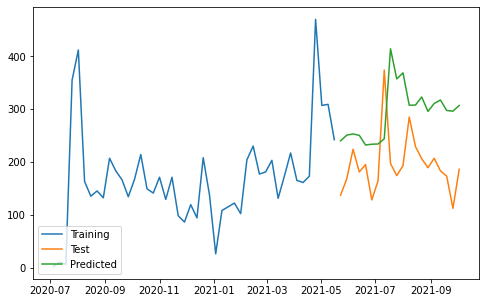

In [397]:
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'lower left')
plt.show()

In [398]:
rms = np.sqrt(mean_squared_error(test, prediction))
rms

121.14531688098444

In [399]:
my_order = (0,1,2)
my_seasonal_order = (1, 1, 0, 12)
# define model
model = SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order)

In [400]:
model_fit = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [401]:
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 Qty   No. Observations:                   46
Model:             SARIMAX(0, 1, 2)x(1, 1, [], 12)   Log Likelihood                -202.568
Date:                             Mon, 11 Oct 2021   AIC                            413.135
Time:                                     05:46:32   BIC                            419.121
Sample:                                 07-05-2020   HQIC                           415.149
                                      - 05-16-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4581      0.209     -2.193      0.028      -0.867      -0.049
ma.L2         -0.3346      

In [402]:
predictions = model_fit.forecast(len(test))
predictions = pd.Series(predictions, index=test.index)
residuals = test - predictions

Text(0, 0.5, 'Error')

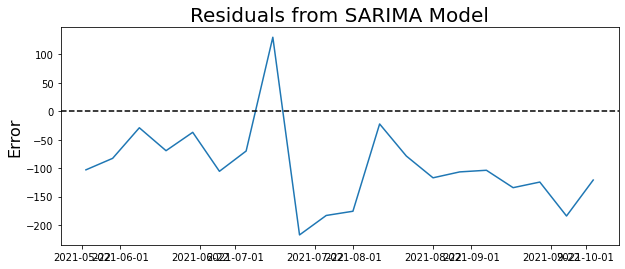

In [403]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

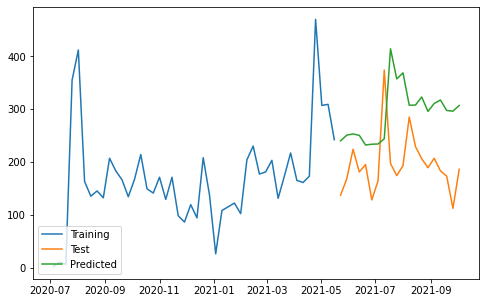

In [404]:
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(predictions,label="Predicted")
plt.legend(loc = 'lower left')
plt.show()

In [405]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test)),4))

Mean Absolute Percent Error: 0.6206


In [406]:
print('Mean Absolute Error:', mean_absolute_error(test, predictions))

Mean Absolute Error: 109.72669426918408


In [407]:
np.sqrt(mean_squared_error(test, predictions))

121.14531688098444

In [408]:
r2_score(test,predictions)

-3.8738870635568636

In [409]:
rolling_predictions = test.copy()
for train_end in test.index:
    train_data = ts[:train_end-timedelta(weeks=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [410]:
rolling_residuals = test - rolling_predictions

Text(0, 0.5, 'Error')

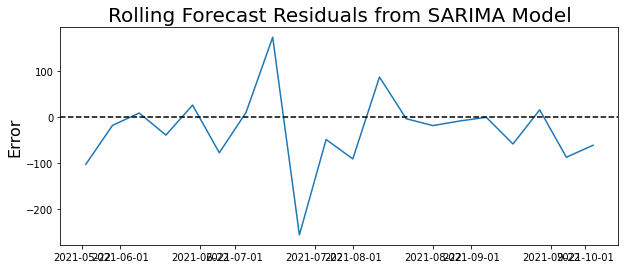

In [411]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

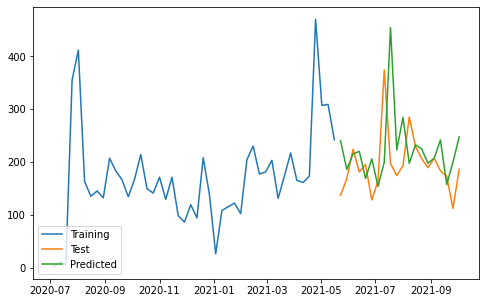

In [412]:
# Rolling predicted
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(rolling_predictions,label="Predicted")
plt.legend(loc = 'lower left')
plt.show()

In [433]:
test

TransactionDate
2021-05-23    137.0
2021-05-30    168.0
2021-06-06    224.0
2021-06-13    181.0
2021-06-20    195.0
2021-06-27    128.0
2021-07-04    164.0
2021-07-11    374.0
2021-07-18    197.0
2021-07-25    174.0
2021-08-01    193.0
2021-08-08    285.0
2021-08-15    229.0
2021-08-22    206.0
2021-08-29    189.0
2021-09-05    207.0
2021-09-12    183.0
2021-09-19    173.0
2021-09-26    112.0
2021-10-03    186.0
Freq: W-SUN, Name: Qty, dtype: float64

In [414]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test)),4))

Mean Absolute Percent Error: 0.3211


In [415]:
print('Mean Absolute Error:', mean_absolute_error(test, rolling_predictions))

Mean Absolute Error: 59.806111644748796


In [416]:
print('Mean Squared Absolute Error:', np.sqrt(mean_squared_error(test, rolling_predictions)))

Mean Squared Absolute Error: 86.56448927895774


In [417]:
# Predict diff
train_diff, test_diff = train_test_split(ts_diff, train_size = 0.7)

In [418]:
model=auto_arima(train_diff,start_p=0,d=1,start_q=0,
          max_p=7,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=7,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=46,n_fits=100)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=438.025, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=425.340, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=432.690, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=427.336, Time=0.39 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=427.336, Time=0.37 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=428.609, Time=0.27 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=429.335, Time=0.62 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=433.222, Time=0.08 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=420.036, Time=0.20 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=424.225, Time=0.08 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=421.374, Time=0.55 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=421.368, Time=0.58 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=422.560, Time=0.23 sec
 ARIMA(2,1,0)(2,1,1)[12]             

In [419]:
my_order = (4,1,1)
my_seasonal_order = (0, 1, 0, 12)
# define model
model = SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order)

In [420]:
model_fit = model.fit()

In [421]:
predictions = model_fit.forecast(len(test))
predictions = pd.Series(predictions, index=test.index)
residuals = test - predictions

Text(0, 0.5, 'Error')

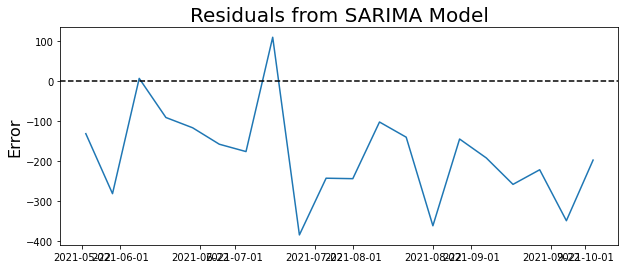

In [422]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

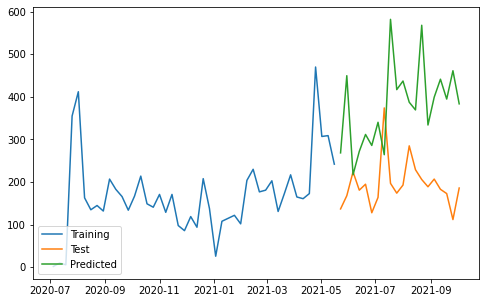

In [423]:
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(predictions,label="Predicted")
plt.legend(loc = 'lower left')
plt.show()

In [424]:
rolling_predictions = test.copy()
for train_end in test.index:
    train_data = ts[:train_end-timedelta(weeks=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [425]:
rolling_residuals = test - rolling_predictions

Text(0, 0.5, 'Error')

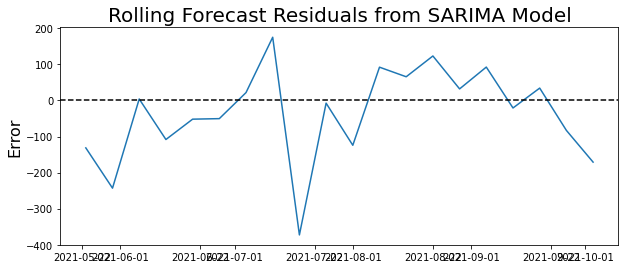

In [426]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

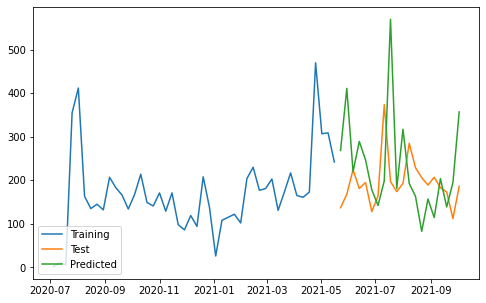

In [427]:
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(rolling_predictions,label="Predicted")
plt.legend(loc = 'lower left')
plt.show()

In [428]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test)),4))

Mean Absolute Percent Error: 0.5332


In [429]:
print('Mean Absolute Error:', mean_absolute_error(test, rolling_predictions))

Mean Absolute Error: 100.30646410776649


In [430]:
print('Mean Squared Absolute Error:', np.sqrt(mean_squared_error(test, rolling_predictions)))

Mean Squared Absolute Error: 133.13825581768748


In [431]:
sdate = datetime.date(2021,5,23)
edate = datetime.date(2022,1,31)
date_range = pd.date_range(sdate,edate,freq='w')

In [432]:
rolling_predictions = test.copy()
for train_end in date_range:
    train_data = ts[:train_end-timedelta(weeks=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
